In [1]:
from utils import get_paper_ref
from operator import itemgetter
from collections import Counter
# import sys
# !{sys.executable} -m pip install sklearn
# !{sys.executable} -m pip install numpy
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

/Users/minjeongshin/miniconda2/lib/python2.7/site-packages/scipy/sparse/lil.py:19: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _csparsetools
/Users/minjeongshin/miniconda2/lib/python2.7/site-packages/scipy/sparse/csgraph/__init__.py:165: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._shortest_path import shortest_path, floyd_warshall, dijkstra,\
/Users/minjeongshin/miniconda2/lib/python2.7/site-packages/scipy/sparse/csgraph/_validation.py:5: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._tools import csgraph_to_dense, csgraph_from_dense,\
/Users/minjeongshin/miniconda2/lib/python2.7/site-packages/scipy/sparse/csgraph/__init__.py:167: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._traversal import breadth_first_order, depth_first_order, 

In [14]:
name_id_pairs = {
#     "steve_blackburn": {"id": 2146610949, "type":"author"},
#     "kathryn_mckinley": {"id": 2115847858, "type":"author"},
#     "james_bornholt": {"id": 2026265091, "type":"author"},
#     "julian_dolby": {"id": 2780161863, "type":"author"},
#     "perry_cheng": {"id": 2140441920, "type":"author"},
    "julian_mcauley": {"id": 2041520510, "type":"author"},
#     "pldi": {"id": 1127352206, "type":"conf"},
    "wsdm": {"id": 1120384002, "type":"conf"},
}

def get_bov(name):
    res = get_paper_ref(name_id_pairs[name]["id"], name_id_pairs[name]["type"])
#     print(res)
    name_id_pairs[name]["numpaper"] = len(res)
    return get_set_of_venues_by_year(res)

def get_set_of_venues_by_year(res):
    references = []
    for p, r in res.items():
        if "References" in r and "Year" in r:
            references.append((r["Year"], r["References"]))
    venues = {}
    for y, ref in references:
        if y not in venues:
            venues[y] = []
        venues[y].extend(ref)
    return venues

def aggr_venues(data):
    venues = []
    for y, ref in data.items():
        venues.extend(ref)
    return venues

def get_vector(bov, author_venue):
    c = Counter(author_venue)
    author_arr = [[float(c[b]) for b in bov]]
    return np.array(author_arr)

In [15]:
data = {}
for name in name_id_pairs.keys():
    data[name] = get_bov(name)

In [16]:
bag_of_venues = set()
sorted_list_bov = list()
for name, y_venues in data.items():
    venues = aggr_venues(y_venues)
    print("{}: len(papers)={}, len(venues)={}, len(set(venues))={}".format(name, name_id_pairs[name]["numpaper"], len(venues), len(set(venues))))
    [bag_of_venues.add(v) for v in venues]
print("Total # of venues = ", len(bag_of_venues))
sorted_list_bov = list(bag_of_venues)
number_of_venues = len(sorted_list_bov)

wsdm: len(papers)=865, len(venues)=9082, len(set(venues))=932
julian_mcauley: len(papers)=58, len(venues)=1246, len(set(venues))=218
('Total # of venues = ', 983)


In [36]:
vec = {}
avg_vec = {}
for name, y_venues in data.items():
    vec[name] = get_vector(sorted_list_bov, aggr_venues(y_venues))
    avg_vec[name] = vec[name]/name_id_pairs[name]["numpaper"]

# Cosine similarity

In [6]:
print(cosine_similarity(vec["steve_blackburn"], vec["kathryn_mckinley"]))
print(cosine_similarity(avg_vec["steve_blackburn"], avg_vec["kathryn_mckinley"]))

[[0.95721714]]
[[0.95721714]]


In [9]:
cosine_similarity(vec["steve_blackburn"], vec["james_bornholt"])

array([[0.35927077]])

In [10]:
cosine_similarity(vec["kathryn_mckinley"], vec["james_bornholt"])

array([[0.44655694]])

In [11]:
cosine_similarity(vec["kathryn_mckinley"], vec["pldi"])

array([[0.75491899]])

In [12]:
cosine_similarity(vec["steve_blackburn"], vec["pldi"])

array([[0.63456002]])

In [11]:
cosine_similarity(vec["julian_mcauley"], vec["wsdm"])

array([[0.63147398]])

In [37]:
pca = PCA(n_components=2)
def plot_pca(vec):
    X = np.zeros((len(vec),number_of_venues))
    for i, v in enumerate(vec.values()):
        X[i] = v
    # print(X)

    pca = PCA(n_components=2)
    pca.fit(X)
    X_pca = pca.transform(X)
    print("original shape:   ", X.shape)
    print("transformed shape:", X_pca.shape)
    z = X_pca[:, 0]
    y = X_pca[:, 1]
    plt.scatter(z, y)
    plt.axis('equal');
    for i, name in enumerate(data.keys()):
        plt.annotate(name, (z[i],y[i]))

# PCA plot sum vectors

('original shape:   ', (2, 983))
('transformed shape:', (2, 2))


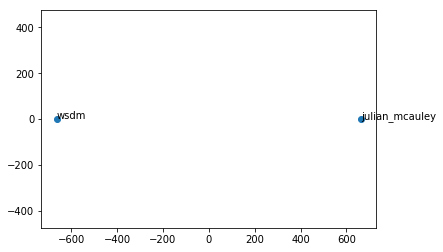

In [38]:
plot_pca(vec)

# PCA plot avg vectors

('original shape:   ', (2, 983))
('transformed shape:', (2, 2))


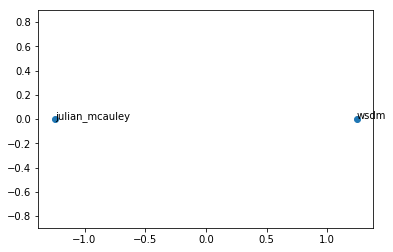

In [39]:
plot_pca(avg_vec)

In [53]:
def year_plot(name, name2=None):
    pick = data[name]
    print((len(pick), number_of_venues))
    X = np.zeros((len(pick), number_of_venues))
    for i, v in enumerate(pick.values()):
        X[i] = get_vector(bag_of_venues, v)
#     print(X)

    pca.fit(X)
    X_pca = pca.transform(X)
    print("original shape:   ", X.shape)
    print("transformed shape:", X_pca.shape)
    
    if name2 == None:
        plt.figure(figsize=(10,8))
    else:
        plt.figure(figsize=(16,10))
    if len(pick) > 1:
        z = X_pca[:, 0]
        y = X_pca[:, 1]
        plt.scatter(z, y, color="blue")
        plt.axis('equal');
        for i, name in enumerate(pick.keys()):
            plt.annotate(name, (z[i],y[i]))
        if name2 != None:
            pick2 = data[name2]
            X2 = np.zeros((len(pick2), number_of_venues))
            for i, v in enumerate(pick2.values()):
                X2[i] = get_vector(bag_of_venues, v)
            pca.fit(X2)
            X2_pca = pca.transform(X2)
            z2 = X2_pca[:, 0]
            y2 = X2_pca[:, 1]
            plt.scatter(z2, y2, color="red")
            for i, name in enumerate(pick2.keys()):
                plt.annotate(name, (z2[i],y2[i]))
            
    else:
        plt.scatter([0],[0])
        plt.annotate(pick.keys()[0], (0,0))

# PCA Year plot (sum vectors)

(11, 983)
('original shape:   ', (11, 983))
('transformed shape:', (11, 2))


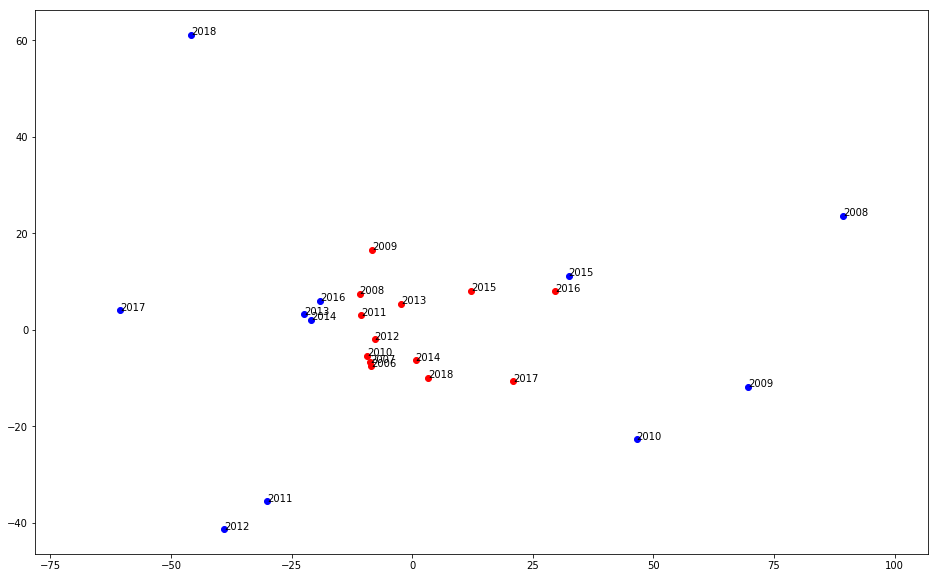

In [54]:
year_plot("wsdm", "julian_mcauley")

(13, 983)
('original shape:   ', (13, 983))
('transformed shape:', (13, 2))


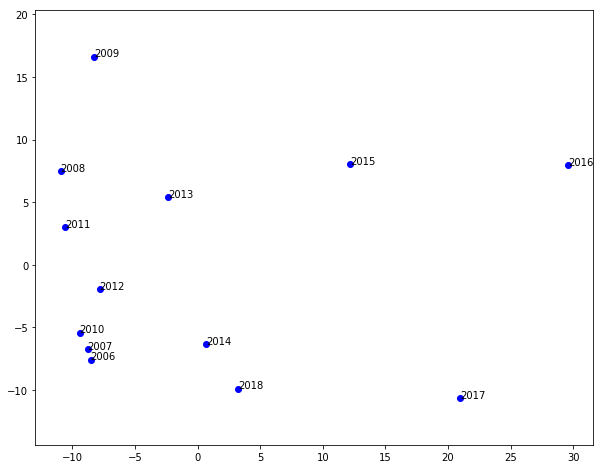

In [55]:
year_plot("julian_mcauley")

('original shape:   ', (32, 1055))
('transformed shape:', (32, 2))


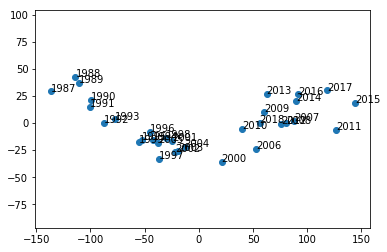

In [12]:
year_plot("pldi")

('original shape:   ', (22, 1055))
('transformed shape:', (22, 2))


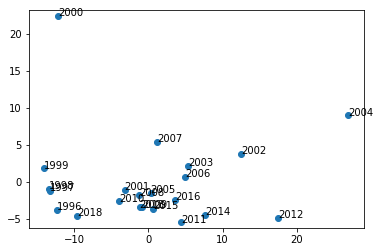

In [19]:
year_plot("steve_blackburn")

('original shape:   ', (19, 1055))
('transformed shape:', (19, 2))


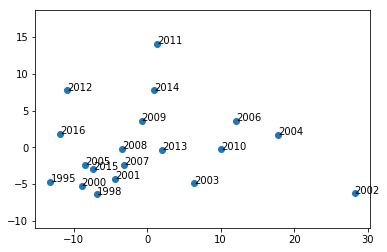

In [20]:
year_plot("kathryn_mckinley")

('original shape:   ', (8, 1055))
('transformed shape:', (8, 2))


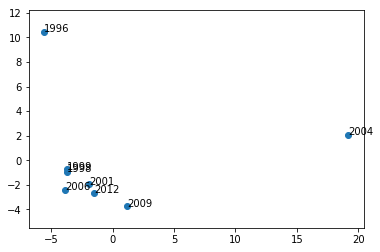

In [21]:
year_plot("perry_cheng")

('original shape:   ', (1, 1055))
('transformed shape:', (1, 1))


/Users/minjeongshin/miniconda2/lib/python2.7/site-packages/sklearn/decomposition/pca.py:423: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


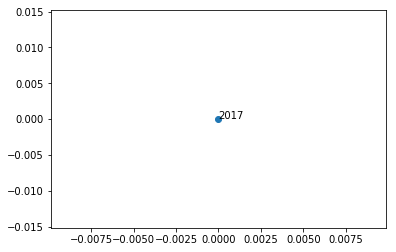

In [22]:
year_plot("james_bornholt")

('original shape:   ', (1, 1055))
('transformed shape:', (1, 1))


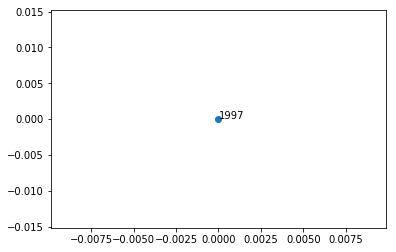

In [23]:
year_plot("julian_dolby")